In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [260]:
inputs_df = pd.read_csv('data/inputs.csv')
inputs_df.columns = ['sample','time','dilution_factor','C00058','C00004','C00037','C00149','C00022','C00065','C00036','C00002','C00020','C00010','C00033','C00158HCT','C00011','C00024','p_hEC11719', 'p_hEC11137','p_hEC6411','p_hEC43117']
inputs_df['time'] = inputs_df['time'].apply(lambda x: (x*60+15)*60)

data_df = pd.read_csv('data/data.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_weights_df = pd.read_csv('data/data_weights.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()

In [261]:
def split_df(df, test_on):
    test_vars_df = df[df['sample'].apply(lambda x: any(name in x for name in test_on))]
    train_vars_df = df[~df['sample'].apply(lambda x: any(name in x for name in test_on))]
    return [test_vars_df, train_vars_df]

test_on = ['pyc_HCT','pyc_HCT_dil','PI', 'es','E_N','TP']
test_vars_df, train_vars_df, test_data_df, train_data_df, test_weights_df, train_weights_df =  sum([split_df(df, test_on) for df in [inputs_df, data_df, data_weights_df]],[])

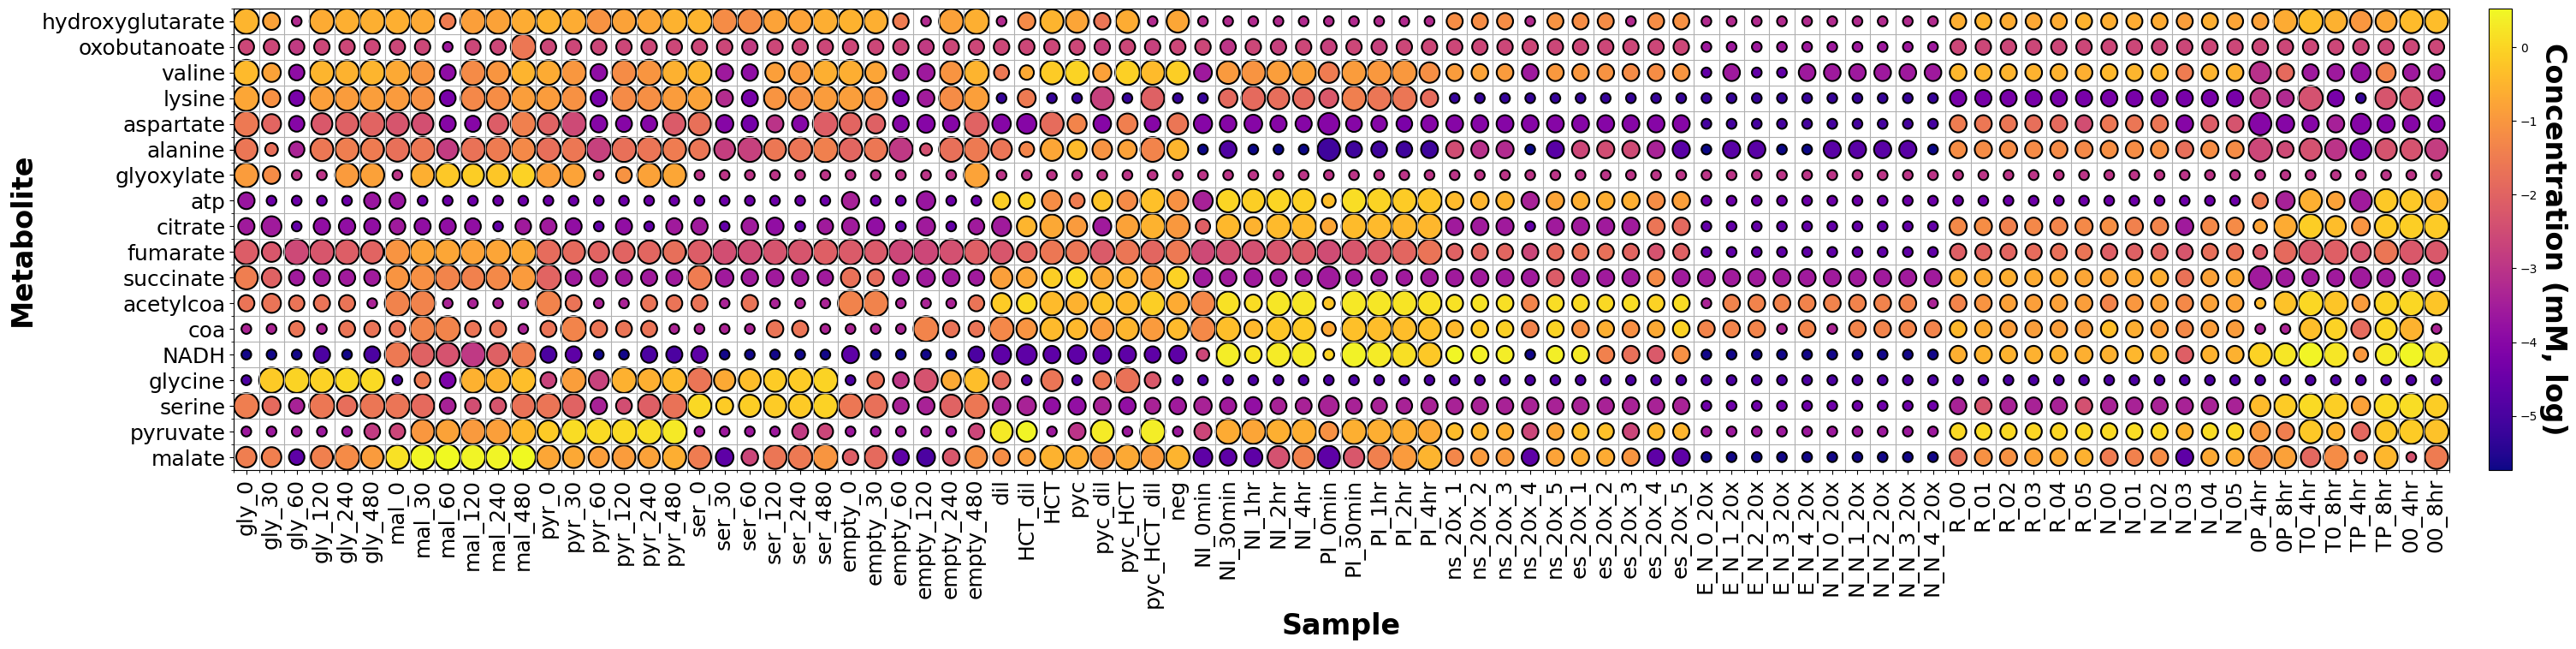

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

def circlemap(data_df, data_weights_df, figsize=(40, 7), ignore = None):
       if ignore:
              data_df = data_df[:-ignore]
              data_weights_df = data_weights_df[:-ignore]
       N, M = data_df.T.shape
       ylabels = data_df.drop(columns=['sample'],inplace=False).columns
       xlabels = data_df['sample']

       x, y = np.meshgrid(np.arange(M), np.arange(N-1))
       s = data_weights_df.drop(columns=['sample'], inplace=False).T.values
       c = np.log10(data_df.drop(columns=['sample'], inplace=False).T.values)

       fig, ax = plt.subplots(figsize=figsize)

       R = s/2
       circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
       col = PatchCollection(circles, array=c.flatten(), cmap="plasma", edgecolors='black', linewidth=1.5)
       ax.add_collection(col)

       ax.set(xticks=np.arange(M), yticks=np.arange(N-1),
              xticklabels=xlabels, yticklabels=ylabels)
       ax.set_xticks(np.arange(M+1)-0.5, minor=True)
       ax.set_yticks(np.arange(N)-0.5, minor=True)
       ax.grid(which='minor')

       plt.xticks(rotation=90)
       plt.tick_params(axis='both', which='major', labelsize=18)

       cbar = fig.colorbar(col, pad = 0.015)
       cbar.set_label('Concentration (mM, log)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})


       plt.xlabel('Sample', fontsize=24, fontdict={'weight': 'bold'})
       plt.ylabel('Metabolite', fontsize=24, fontdict={'weight': 'bold'})

       plt.show()
       
circlemap(data_df, data_weights_df, ignore=12)

In [263]:
test_index_map = pd.merge(test_vars_df, test_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']]
train_index_map = pd.merge(train_vars_df, train_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']]

In [264]:
train_vars = [train_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]
test_vars = [test_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]

train_metadata = [{}]
train_metadata[0]['sample_lables'] = list(train_vars[0].keys())
train_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
train_metadata[0]['timepoints'] = train_index_map.groupby('index')['time'].apply(list).to_dict()

test_metadata = [{}]
test_metadata[0]['sample_lables'] = list(test_vars[0].keys())
test_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
test_metadata[0]['timepoints'] = test_index_map.groupby('index')['time'].apply(list).to_dict()

train_data=[{}]
train_weights=[{}]
for index, samples in train_index_map.groupby('index')['sample'].apply(list).items():
    train_data[0][index]=train_data_df.loc[train_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    train_weights[0][index]=train_weights_df.loc[train_weights_df['sample'].isin(samples)].drop(columns=['sample']).values

test_data=[{}]
test_weights=[{}]
for index, samples in test_index_map.groupby('index')['sample'].apply(list).items():
    test_data[0][index]=test_data_df.loc[test_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    test_weights[0][index]=test_weights_df.loc[test_weights_df['sample'].isin(samples)].drop(columns=['sample']).values


In [308]:
# load SBML model
modelfile = os.getcwd()+'/models/240828_M0.sbml'
r = te.loadSBMLModel(modelfile)

In [8]:
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat' in p]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p ]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+150:sbml.find('<initialAssignment symbol="'+s+'">')+150+len(s)]).split(' ')[0] for s in metabolites] if 'v' in v]

parameter_labels = kcat_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + metabolites_labels
parameter_labels.append('rel0') # what are good bounds for this?
# last parameter is reserved for heterelogous enzyme multiplier
parameter_labels.append('rel1') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*100 for i in kcat_labels] + 
                 [r[i]*100 for i in km_labels] + 
                 [r[i]*100 for i in ki_labels] +
                 [1 for _ in Gnc_labels] +
                 [1 for _ in Gc_labels] +
                 [100 for _ in metabolites_labels] + 
                 [100, 100])

lower = np.array([r[i]/100 for i in kcat_labels] + 
                 [r[i]/100 for i in km_labels] + 
                 [r[i]/100 for i in ki_labels] +
                 [1/100 for _ in Gnc_labels] +
                 [1/100 for _ in Gc_labels] +
                 [1/100 for _ in metabolites_labels] + 
                 [1/100, 1/100])

p_initial = np.array([r[i] for i in kcat_labels] + 
                     [r[i] for i in km_labels] + 
                     [r[i] for i in ki_labels] +
                     [0.9 for _ in Gnc_labels] +
                     [0.9 for _ in Gc_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1, 1])

widths = np.array([10 for _ in kcat_labels] + 
                  [10 for _ in km_labels] + 
                  [10 for _ in ki_labels] +
                  [1.1 for _ in Gnc_labels] +
                  [1.1 for _ in Gc_labels] +
                  [10 for _ in metabolites_labels] + 
                  [10, 10])

In [10]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob,test_myprob = [SBMLGlobalFit_Multi_Fly(
    model = t['models'], 
    data = t['data'], 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=t['metadata'],
    variables=t['variables'],
    scale=True,
    dlambda = 1) for t in [train, test]]

with open('train_myprob.obj', 'wb') as file:
    pickle.dump(train_myprob, file)

train_prob = pg.problem(train_myprob)
test_prob = pg.problem(test_myprob)

In [11]:
import ipyparallel as ipp
from src.fitting.pygmo_bfes import pickleless_bfe

client = ipp.Client(profile='cheme-ecfers')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS');

def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())

client[:].apply_sync(set_affinity_on_worker)

udbfe = pickleless_bfe(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs = {}, temp_dv_path = os.getcwd()+'/models/binaries', prob = {'train':train_prob})
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'},view_kwargs = {})
mybfe = pg.bfe(udbfe)

In [12]:
# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
replicates = 1
for i in range(replicates):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.1, variant=5, neighb_type=2, neighb_param=4, memory=False)
    # a = pg.gaco(gen=10)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(train_prob, size = 0))

In [ ]:
total_nodes = len(client[:])*1
for p in pops:
    xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p/w,p*w, total_nodes)) for p,w in zip(p_initial,widths)])).T
    fs = udbfe(train_prob,xs.reshape(-1))
    list(map(p.push_back, xs, fs[:,np.newaxis]))

with open('checkpoint_t.dat', 'wb') as file:
    pickle.dump(pops, file)

In [13]:
import pickle

with open('logs_t.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

with open('checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)

In [21]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
# logs = [[] for _ in range(replicates)]
# test_fit = []
for i in range(200):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]

    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))
    
    # test_fit.append([[udbfe(test_prob,p.get_x().reshape(-1), mode = 'test')] for p in pops])

    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('logs_t.dat', 'wb') as file:
        pickle.dump([logs,test_fit], file)

    with open('checkpoint_t.dat', 'wb') as file:
        pickle.dump(pops, file)
    
    # # replace the worst 10% of the population with new random individuals, from same distribution as the initial population
    # for p in pops:
    #     replace = int(len(p)/10)
    #     xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p/w,p*w, replace)) for p,w in zip(p_initial,widths)])).T
    #     fs = udbfe(train_prob,xs.reshape(-1))
    #     list(map(p.set_xf, np.argsort(p.get_f()[:,0])[-replace:], xs, fs[:,np.newaxis]))
    
    # udbfe._view.client.purge_everything()

    # if np.min([p.champion_f for p in pops]) < prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__()):
    #     break
    

27-06-2024, 01:27:32 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            600        14.7015      0.0388845        16.7706        13.1999
      2           1200        14.7015      0.0274179        16.7706        13.3221
      3           1800        14.7015      0.0143475        16.7706        13.3807
      4           2400        14.7015      0.0148029        16.7706        13.2329
      5           3000        14.7015      0.0264459        16.7706        13.0571

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            600        14.7015      0.0378676        16.7706         13.207
      2           1200        14.7015      0.0265267        16.7706        13.3324
      3           1800        14.7015      0.0141428        16.7706        13.3917
      4           2400        14.7015      0.0147922        16.7706        13.2435
      5           3000        14.7015    

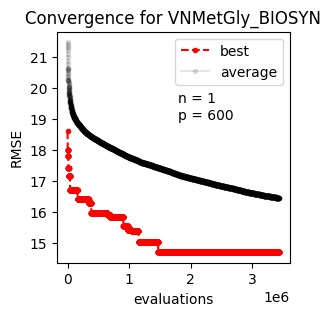

In [15]:
results = [np.concatenate(l,axis=0) for l in logs]
plt.figure(figsize=(3,3))
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,2],'.r--', label = 'best') for res in results]
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,4],'.k-', alpha = 0.1, label = 'average') for res in results]
# plt.xscale('log')

# test_evals = np.arange(1,len(np.squeeze(np.array(test_fit)))*10,10)
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).mean(axis=1),'or-', alpha = 0.4, label = 'average, test')
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).min(axis=1),'or-', label = 'best, test')

# plt.yscale('log')
plt.ylabel('RMSE')
plt.xlabel('evaluations')
plt.title('Convergence for VNMetGly_BIOSYN')  
plt.legend()
plt.text(1800000, 19, 'n = 1 \np = 600');

In [30]:
test_myprob._setup_rr()
train_myprob._setup_rr()

all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:6],:]):
    # test_res = test_myprob._simulate(test_myprob._unscale(c))
    uc = train_myprob._unscale(c)
    train_res = train_myprob._simulate(uc)
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    # [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]


/tmp/ipykernel_176/4089472006.py:15: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

/tmp/ipykernel_176/4089472006.py:35: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.



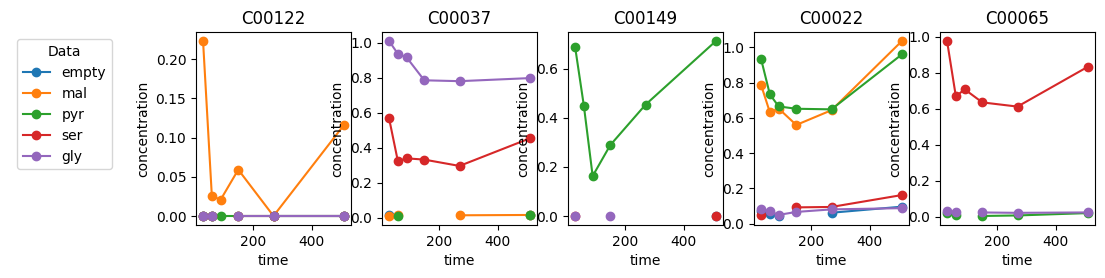

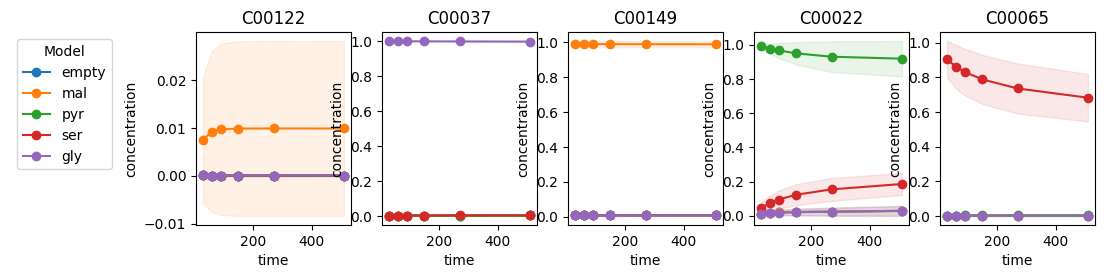

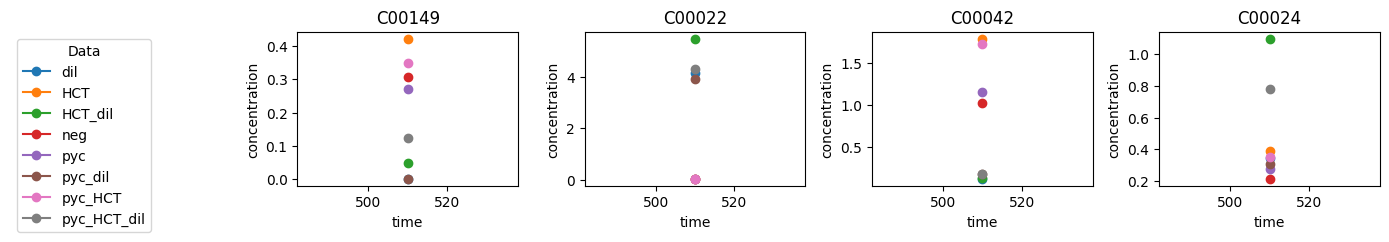

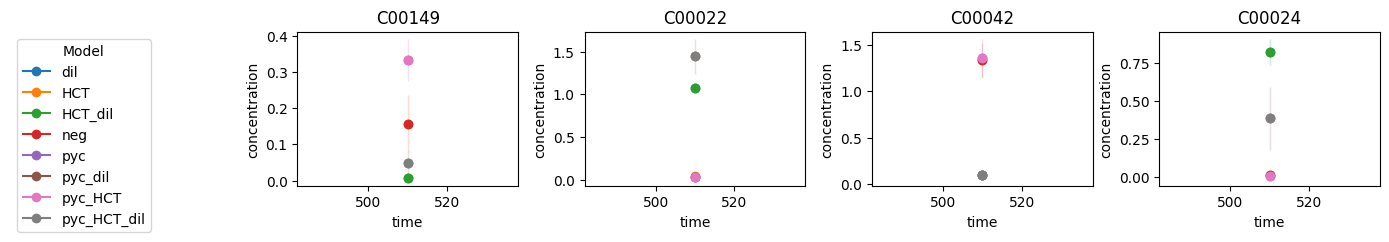

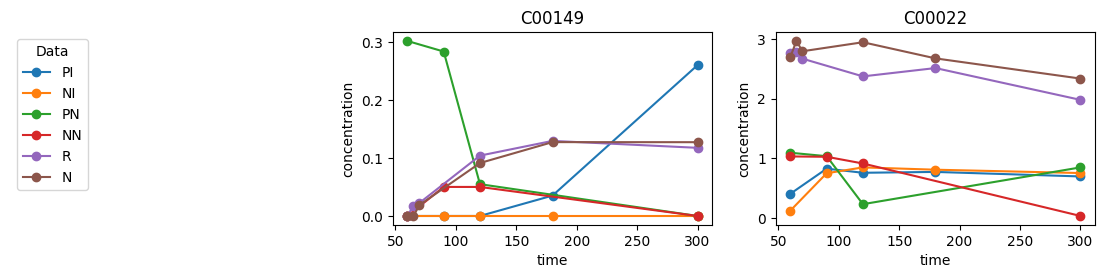

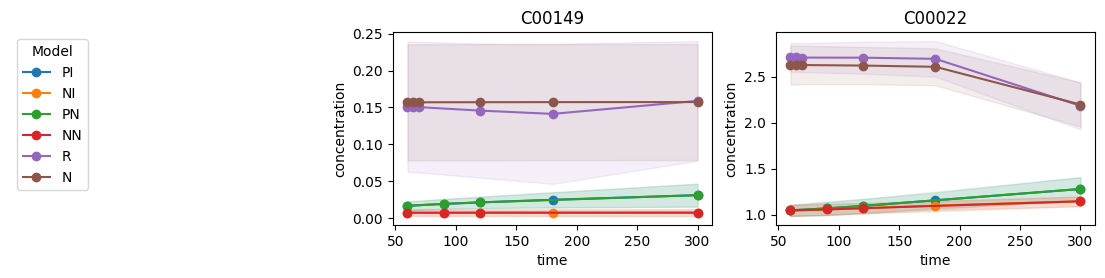

In [31]:
for metadata, measurements, results in zip(train_myprob.metadata, train_myprob.data, all_results[0]):    
    plt.figure(figsize=(14,2.5))
    for s in metadata['sample_labels']:
        for i,m in enumerate(metadata['measurement_labels']):
            plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
            plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
            plt.title(m)
            plt.xlabel('time')
            plt.ylabel('concentration')

    plt.subplot(1,5,1)
    [plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
    plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
    plt.gca().axis('off')
    plt.tight_layout()

    
    plt.figure(figsize=(14,2.5))
    for s in metadata['sample_labels']:
        for i,m in enumerate(metadata['measurement_labels']):
            plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
            if s in results.keys():
                mean = np.mean(results[s],0)[:,i]
                std = np.std(results[s],0)[:,i]
                p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
                plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
            plt.title(m)
            plt.xlabel('time')
            plt.ylabel('concentration')

    plt.subplot(1,5,1)
    [plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels'] if s in results.keys()]
    plt.legend(results.keys(), loc='upper left', title='Model')
    plt.gca().axis('off')
    plt.tight_layout()
        

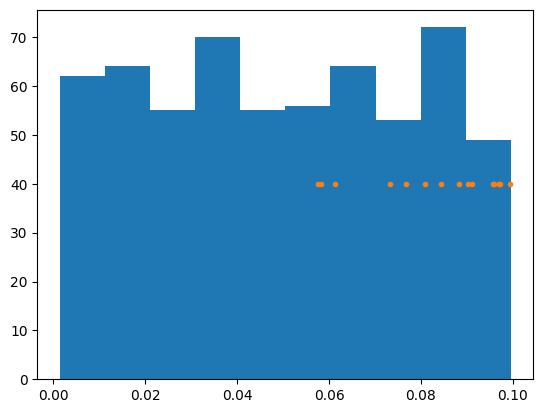

In [15]:
p = -1
N = 15
plt.hist(pops[0].get_x()[:,p])
# plt.hist(xs[:,p], alpha = 0.5)
plt.plot(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:N],:][:,p], [40]*N,'.')

In [16]:
uc[600]

0.05179176833832805

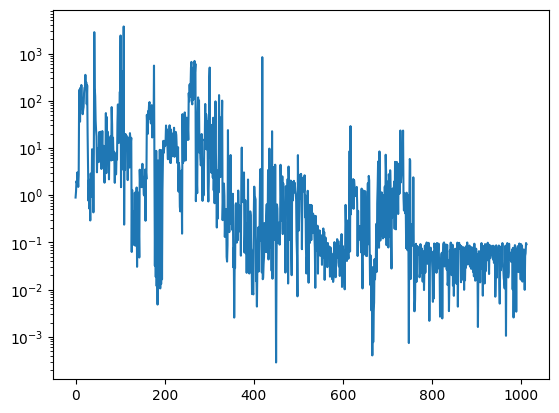

In [16]:
plt.plot(uc)
plt.yscale('log')

(array([  2.,   3.,   7.,  13.,  35.,  82.,  98., 132., 138.,  90.]),
 array([2.35297178, 2.3594543 , 2.36593683, 2.37241935, 2.37890188,
        2.3853844 , 2.39186693, 2.39834945, 2.40483198, 2.4113145 ,
        2.41779703]),
 <BarContainer object of 10 artists>)

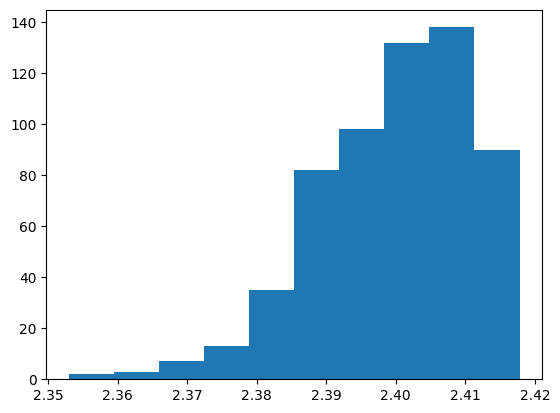

In [18]:
plt.hist((fs))

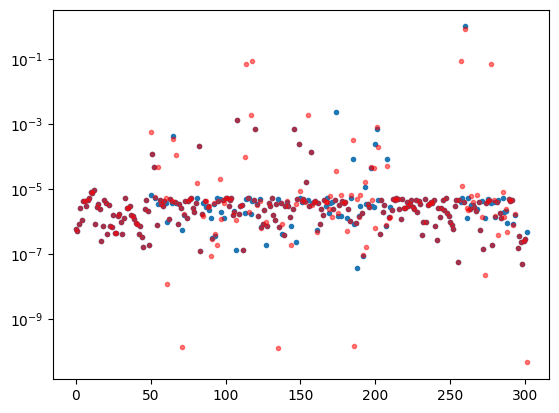

In [19]:
plt.plot(train_res[0]['ser'][0,:],'.')
plt.plot(train_res[0]['ser'][-1,:],'.r', alpha =0.5)

plt.yscale('log')

In [9]:
top_pop = pg.population(pg.problem(myprob), size = 0)
list(map(top_pop.push_back, pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:],pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]));

In [10]:
top_pop = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:]

In [11]:
def multi_minimize(pop, prob, rank):
    from scipy.optimize import minimize, Bounds 
    bounds = Bounds(prob.get_bounds()[0],prob.get_bounds()[1],True)
    options = {'maxfev':2500,'adaptive':True}
    results = minimize(prob.fitness, pop[rank,:], method='Nelder-Mead', bounds = bounds, options = options)
    return results

In [12]:
udbfe._view.push({"multi_minimize": multi_minimize,"pop":top_pop}, block = True);

In [13]:
local_fits = udbfe._view.apply_sync(lambda x,y,z: multi_minimize(x,y,z), ipp.Reference("pop"), ipp.Reference("prob"), ipp.Reference("rank"))

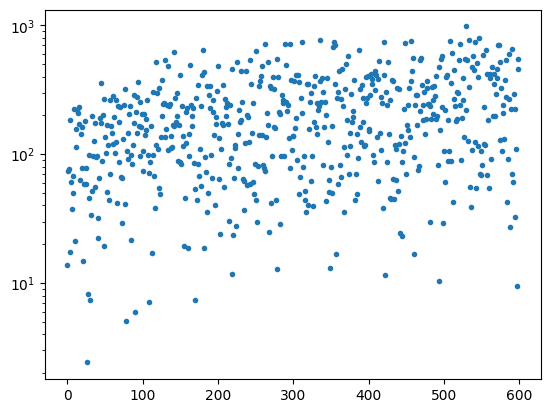

In [46]:
plt.plot(np.squeeze(pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]) - [fit.fun for fit in local_fits],'.')
plt.yscale('log')

In [38]:
print(np.arange(15))
print(np.argsort([fit.fun for fit in local_fits])[:15])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 4  9  0  1  2 16 13 14  5  3 45  7 12  6 15]


In [40]:
np.argsort([fit.fun for fit in local_fits])[:15]
local_fits[0].x

array([0.00115716, 0.0521422 , 0.06525401, ..., 0.16534265, 0.24093261,
       0.12788583])

In [42]:
myprob._setup_rr()
all_results_local = {s:[] for s in metadata['sample_labels']}
for k,c in enumerate(np.argsort([fit.fun for fit in local_fits])[:15]):
    res_dict = myprob._simulate(myprob._unscale(local_fits[c].x))
    [all_results_local[s].append(res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]) for s in metadata['sample_labels']]

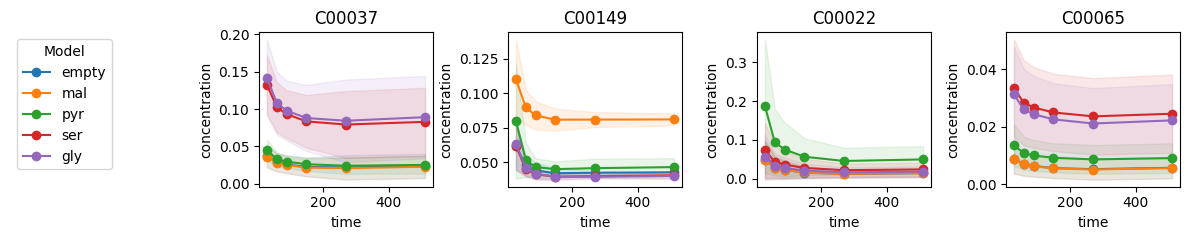

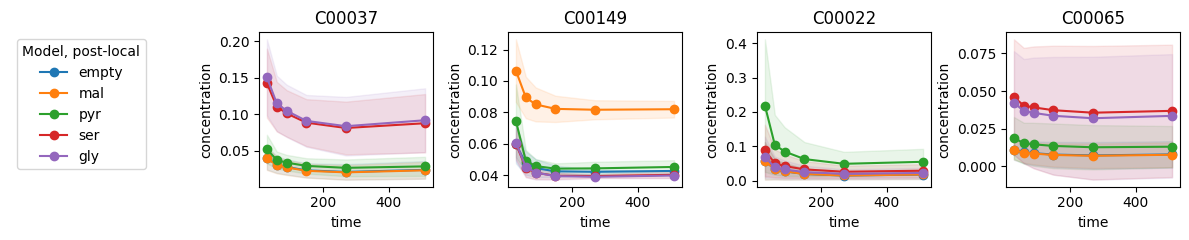

In [47]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results[s],0)[:,i]
        std = np.std(all_results[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()

plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results_local[s],0)[:,i]
        std = np.std(all_results_local[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model, post-local')
plt.gca().axis('off')
plt.tight_layout()

In [20]:
top = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:15],:]
mean = np.array(top.mean(axis=0))
std = np.array(top.std(axis=0))

std[(mean<0.8)*(mean>0.1)] = np.nan
plot_labels = np.array(parameter_labels)
plot_labels[(mean<0.8)*(mean>0.1)] = ''
inital = test_myprob._scale(p_initial)
inital[(mean<0.8)*(mean>0.1)] = np.nan
mean[(mean<0.8)*(mean>0.1)] = np.nan


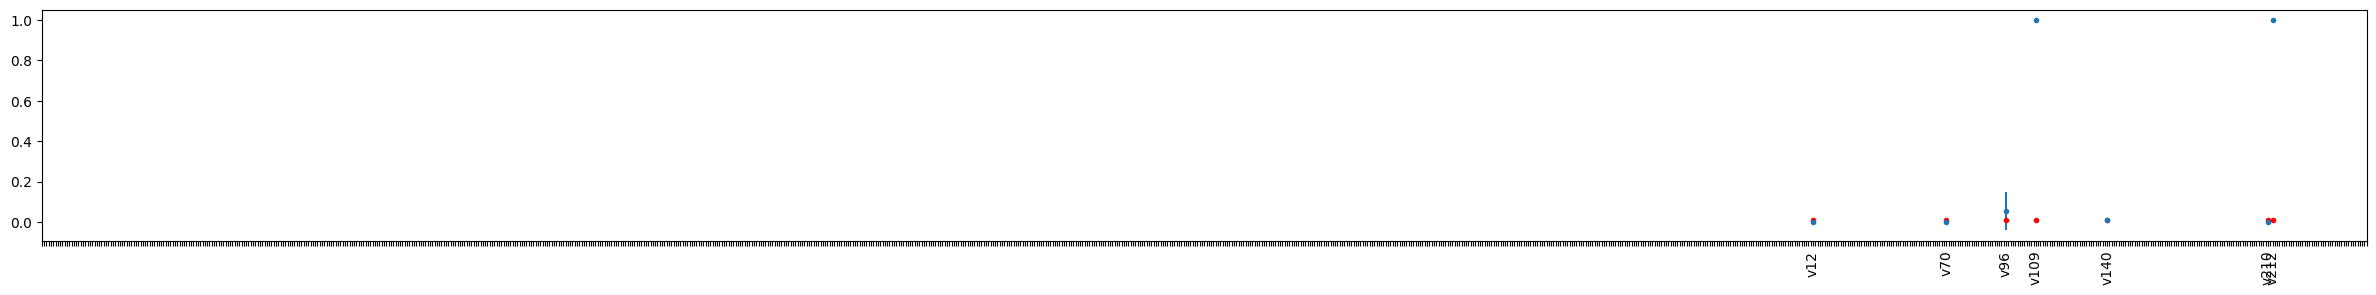

In [21]:
plt.figure(figsize=(30,3))
plt.errorbar(range(len(top[0,:])),mean,yerr=std, fmt='.')
plt.plot(range(len(top[0,:])),inital,'r.')
plt.xticks(range(len(plot_labels)),plot_labels, rotation = 90);

In [34]:
train_myprob.r[0].getValue('Kcat_F_R1')

5.156910298476282

In [39]:
uc[-1]

1.0